# Optimizing Masks to create WTs

In [1]:
# importing necessary libraries and the cnn architecture I defined

from cnn_architecture import CNN2Model
from utils import *
from load_datasets import load_and_prep_dataset

import tensorflow_datasets as tfds
#import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat
import copy

# all the extra stuff for supermasks

2024-05-29 19:22:27.939022: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.test.is_built_with_cuda()

True

all the variables i have to check their meaning:
- use bias
- dynamik scaling
- sigmoid bias
- use learning phase


In [3]:
class MaskedDense(tf.keras.Layer):
    def __init__(self, units=32, activation = tf.keras.activations.relu):
        super().__init__()
        self.units = units
        self.activation = activation

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=False,
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.Constant(value=0.0000000001),
            trainable=False,
            name="bias",
        )
        self.mask = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=None),
            trainable=True,
            name="mask",
        )

    # Defines the computation
    #@tf.function
    def call(self, inputs):
        #masked_weights = tf.math.multiply(self.kernel, tf.nn.sigmoid(self.mask))
        masked_weights = tf.math.multiply(self.kernel, self.mask)
        net_activation = tf.linalg.matmul(inputs, masked_weights) + self.bias
        return self.activation(net_activation)
    
    def normalize_pruning_rate(self, p_rate):
        percentile = np.percentile(self.mask, p_rate)
        self.kernel = tf.math.subtract(self.kernel+0.5, percentile)

In [4]:
class CNN2ModelMasked(tf.keras.Model):
    
    # basic
    def __init__(self, p_rates = [90,20,10]):
        super(CNN2ModelMasked, self).__init__()
        
        # set biases to a value that is not exactly 0.0, so they don't get handled like pruned values
        self.bias_in = tf.keras.initializers.Constant(value=0.0000000001)
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),input_shape=(32, 32, 64)) # [batchsize,16,16,64]
        self.flatten = tf.keras.layers.Flatten() # [batch_size,16384]
        self.dense1 = MaskedDense(256, activation=tf.keras.activations.relu) # [batch_size,256]
        self.dense2 = MaskedDense(256, activation=tf.keras.activations.relu) # [batch_size,256]
        self.dense3 = MaskedDense(10, activation=tf.keras.activations.softmax) # [batch_size,256]
        
        # Making the weights of the conv layers untrainable
        self.conv1.trainable = False
        self.conv2.trainable = False
    
    #@tf.function
    def call(self, inputs):
        
        # adjust the dense layers to be multiplayed with trainable mask (which gets assigned binary values for this step)
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x
    
    def normalize_pruning_rate(self, p_rates):
        self.dense1.normalize_pruning_rate(p_rates[0])
        self.dense2.normalize_pruning_rate(p_rates[1])
        self.dense3.normalize_pruning_rate(p_rates[2])

    def get_binary_masks(self):
        masks = []
        for tv in self.trainable_variables:
            masks.append(tf.math.round(tf.nn.sigmoid(tv)))
        return masks

In [5]:
# modified train loop to also work with sparse networks (such that pruned weights remain frozen at 0.0)

def train_mask(train, test, model, num_epochs=5):
    
    # hyperparameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    # initializing training statistics
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []

    # make sure the mask of the model is fitted to the pruning rates
    model.normalize_pruning_rate(p_rates = [90,20,10])

    for epoch in tqdm(range(num_epochs), leave=False, desc="training epochs"):
        
        #train step
        for x, t in train:
            with tf.GradientTape() as tape:
                pred = model(x)
                loss = loss_function(t, pred)
                train_losses.update_state(t, pred)
                train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        print(get_pruning_rates(model.get_binary_masks()))
        model.normalize_pruning_rate(p_rates = [90,20,10])
        print(get_pruning_rates(model.get_binary_masks()))

        # test step
        for x, t in test:
            pred = model(x)
            test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            test_losses.update_state(t, pred)
        
        # updataing training statistics
        train_acc.append(train_accuracy.result().numpy())
        test_acc.append(test_accuracy.result().numpy())
        train_l.append(train_losses.result().numpy())
        test_l.append(test_losses.result().numpy())
        train_accuracy.reset_state()
        test_accuracy.reset_state()
        train_losses.reset_state()
        test_losses.reset_state()
        
    # collecting losses in a dictionary
    losses = { "test loss":test_l , "training loss":train_l , "test accuracy":test_acc , "training accuracy":train_acc}
    
    return  losses

2024-05-29 19:22:32.260353: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 19:22:32.309591: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 19:22:32.309807: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


2024-05-29 19:23:00.279447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
training epochs:  10%|█         | 1/10 [00:25<03:45, 25.01s/it]2024-05-29 19:23:21.282157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


2024-05-29 19:23:23.921323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
training epochs:  20%|██        | 2/10 [00:48<03:13, 24.21s/it]2024-05-29 19:23:44.924349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


2024-05-29 19:23:47.585050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
training epochs:  30%|███       | 3/10 [01:12<02:47, 23.96s/it]2024-05-29 19:24:08.668883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


2024-05-29 19:24:11.319289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
training epochs:  40%|████      | 4/10 [01:36<02:23, 23.87s/it]2024-05-29 19:24:32.338803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


2024-05-29 19:24:34.996527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
training epochs:  50%|█████     | 5/10 [01:59<01:59, 23.80s/it]2024-05-29 19:24:56.230677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


2024-05-29 19:24:58.882401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
training epochs:  60%|██████    | 6/10 [02:23<01:35, 23.83s/it]2024-05-29 19:25:19.812764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


2024-05-29 19:25:22.521072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
training epochs:  70%|███████   | 7/10 [02:47<01:11, 23.77s/it]2024-05-29 19:25:43.542663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


2024-05-29 19:25:46.161351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
training epochs:  80%|████████  | 8/10 [03:10<00:47, 23.73s/it]2024-05-29 19:26:07.112679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


2024-05-29 19:26:09.749780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
training epochs:  90%|█████████ | 9/10 [03:34<00:23, 23.68s/it]2024-05-29 19:26:30.791370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]


2024-05-29 19:26:33.442483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


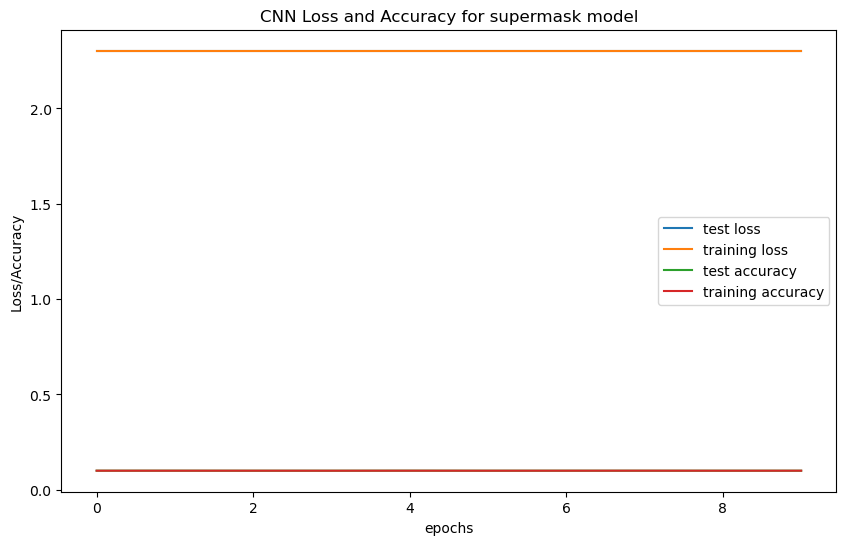

In [6]:
train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=60, shuffle_size=512)

model = CNN2ModelMasked()
model(list(train_dataset)[0][0])
initial_weights = model.get_weights()
#print("initial_weights: ")
#for matrix in initial_weights:
    #print(matrix.shape)
#print("trainable variables: ")
#for matrix in model.trainable_variables:
    #print(matrix)
#model.summary()

losses = train_mask(train_dataset, test_dataset, model,num_epochs=10)
plot_losses("CIFAR", "TestSuperMaskOptimization", losses,"CNN Loss and Accuracy for supermask model")

debugging to do:
- check paper for optimizer
- make the call function simpler
- research other examples of unusual trainable parameters in models